In [5]:
import numpy as np
from typing import Callable

class AdamMomentum:
    def __init__(self, dL:Callable, lr:float=0.001, beta1:float=0.9, beta2:float=0.999, epsilon:float=1e-8, weight_decay: float = 0, lambda_l2: float = 0, epochs: int = 1000):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.lambda_l2 = lambda_l2
        self.m = 0
        self.v = 0
        self.dL = dL
        self.iteration = 1
        self.epochs = epochs
        self.global_error_tolerance = 1e-5
        self.theta_result = []
        self.m_result = []
        self.v_result = []

    def __global_error__(self, theta_new: float , theta_old: float) -> float:
            diff = theta_new - theta_old
            return np.abs(diff)

    def solve(self, theta_initial):

        theta = theta_initial
        while self.iteration <= self.epochs:
            
            self.theta_result.append(theta)
            self.m_result.append(self.m)
            self.v_result.append(self.v)

            theta_old = theta
            dL_value = self.dL(theta)
            
            if self.lambda_l2 != 0:
                dL_value  += self.lambda_l2 / 2 * theta

            self.m = self.beta1 * self.m + (1 - self.beta1) * dL_value
            self.v = self.beta2 * self.v + (1 - self.beta2) * (dL_value ** 2)
            m_hat = self.m / (1 - self.beta1 ** self.iteration)
            v_hat = self.v / (1 - self.beta2 ** self.iteration)
            
            update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
            if self.weight_decay != 0:
                theta = (1 - self.weight_decay) * theta - update
            else:
                theta -= update
            
            global_error = self.__global_error__(theta_new=theta, theta_old=theta_old)

            if self.iteration % 50 == 0:
                print(f'Epoch: {self.iteration}, Error: {global_error}.')

            self.iteration += 1

        print(f'Last epoch: {self.iteration}, Error: {global_error}.')

        return self.theta_result, self.m_result, self.v_result, self.iteration


Adam Configuration: {'beta1': 0.9, 'beta2': 0.9, 'lr': 0.1}
Epoch: 50, Error: 0.009876221292510312.
Last epoch: 51, Error: 0.009876221292510312.


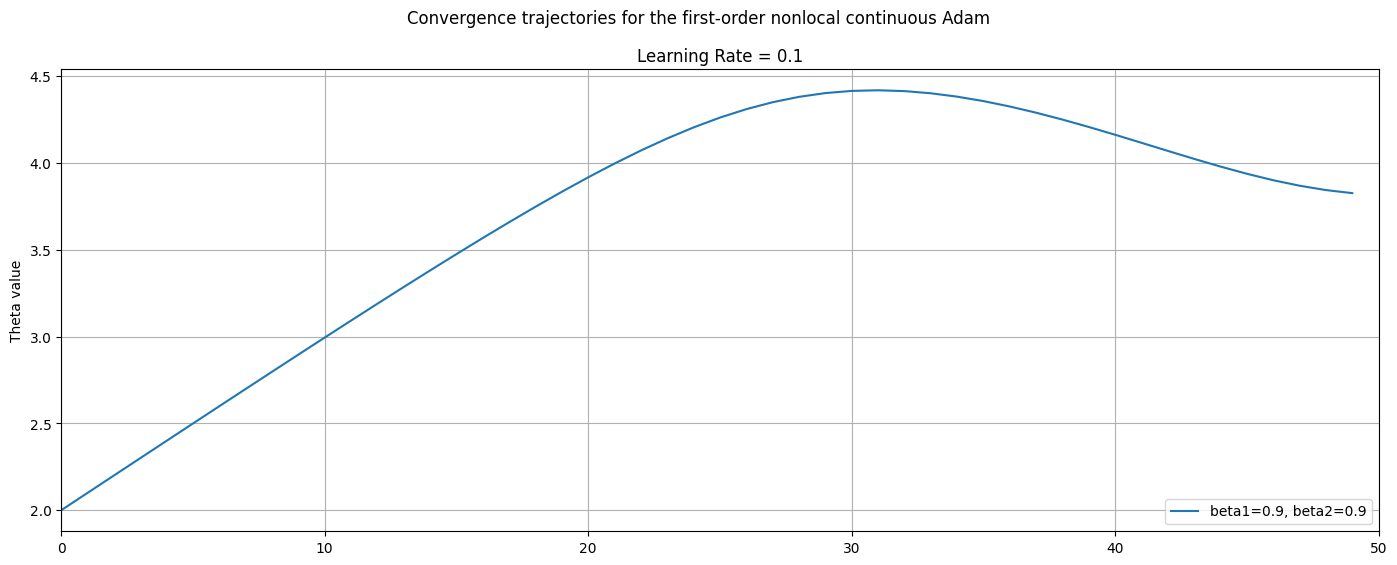

In [44]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

param_grid = {'lr': [0.1], 'beta1': [0.9],'beta2': [0.9]}
n_learning_rates = len(param_grid['lr'])
param_list = list(ParameterGrid(param_grid))

fig, axs = plt.subplots(ncols=n_learning_rates, figsize=(17, 6), sharex=False, sharey=True)   
fig.suptitle('Convergence trajectories for the first-order nonlocal continuous Adam')

dL = lambda y: 2 * (y - 4)

for i, lr in enumerate(param_grid['lr']):

    ax = axs[i] if n_learning_rates > 1 else axs
    filtered_params = [p for p in param_list if p['lr'] == lr]

    if lr == 0.1:
        epochs = 50
    elif lr == 0.01:
        epochs = 300
    else:
        epochs = 3000

    for params in filtered_params:
        theta_initial= 2.0
        
        print(f'\nAdam Configuration: {params}')
        solver = AdamMomentum(dL=dL, lr=lr, beta1=params['beta1'], beta2=params['beta2'], epochs=epochs)
        solver.solve(theta_initial=theta_initial)

        label = f"beta1={params['beta1']}, beta2={params['beta2']}"
        ax.set_title(f'Learning Rate = {lr}')
        ax.plot(solver.theta_result, label=label)
        ax.set_xlim([0, epochs])
        ax.grid(True)
        ax.set_ylabel('Theta value')
        ax.legend(loc = 'lower right')

In [40]:
v

[0,
 1.5999999999999996,
 2.8840000003799995,
 3.8951512929357786,
 4.6716919029844775,
 5.2474630778188445,
 5.652372221648012,
 5.912807730225846,
 6.052010634990307,
 6.090407478987604,
 6.045908409694514,
 5.934174082176922,
 5.768854615393238,
 5.561803530823539,
 5.3232693222589305,
 5.062067055050687,
 4.785732169099259,
 4.500658459158748,
 4.212222025461229,
 3.9248928239950227,
 3.6423352956680097,
 3.367499413599488,
 3.10270335437922,
 2.8497088688136647,
 2.609790297204373,
 2.3837980409194426,
 2.1722171643100237,
 1.9752216588324465,
 1.7927247565721154,
 1.6244255376673982,
 1.4698519423122758,
 1.3284001820087157,
 1.1993704564411052,
 1.0819988309791424,
 0.975485121932161,
 0.8790166742122447,
 0.7917879949969692,
 0.7130163171104907,
 0.6419532919218343,
 0.5778931357329646,
 0.5201776586002488,
 0.46819867671746673,
 0.42139834132914794,
 0.37926790802361887,
 0.3413454258750652,
 0.30721275640455226,
 0.27649224977217535,
 0.24884332149199181,
 0.22395909632867012

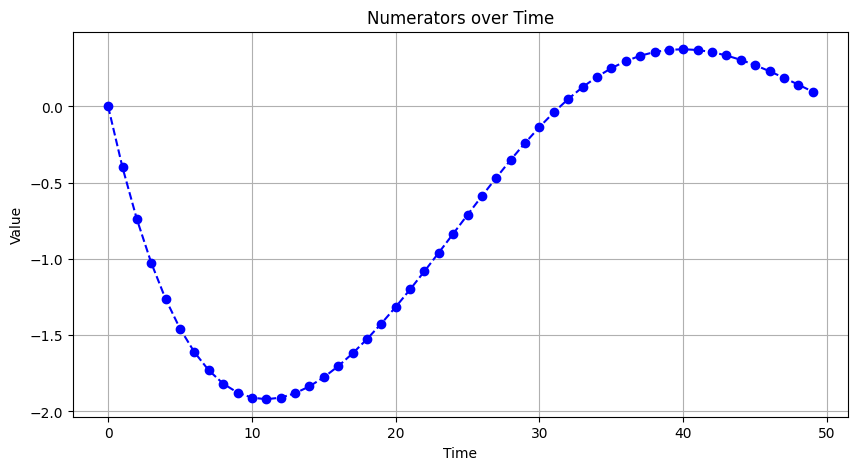

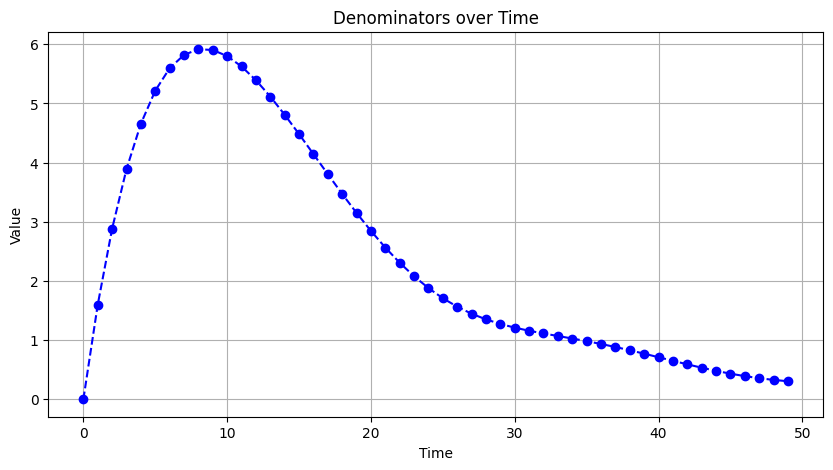

In [45]:
m = solver.m_result
v = solver.v_result

def plot_values(values, title):

    plt.figure(figsize=(10, 5))
    plt.plot(values,  '--bo', label='Values over Time m_hat',)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_values(m, 'Numerators over Time')
plot_values(v, 'Denominators over Time')

In [42]:
from scipy.integrate import fixed_quad
from scipy.interpolate import interp1d
from concurrent.futures import ThreadPoolExecutor
from numba import njit
from typing import Callable
import numpy as np

class NonlocalSolverMomentum:
    def __init__(self, f: Callable, dL: Callable, t_span: list, y0: np.array, betas: list,
                 alpha: float, lambda_:float = 0, verbose: bool = True):
        
        np.random.seed(33)

        self.f = f
        self.t_span = t_span
        self.y0 = y0 
        self.alpha = alpha
        self.t = np.arange(t_span[0], t_span[1], alpha)
        self.betas = betas
        self.b = 1/alpha * np.array([1 - betas[0], 1 - betas[1]])
        self.lambda_ = lambda_
        self.k = lambda i, s: self.b[i-1] * np.exp( - self.b[i-1] * s)
        self.dL = dL
        self.v_initial = 1.5999
        self.m_initial = -4.0
        
        self.epsilon = 1e-8

        self.smoothing_factor = 0.5
        self.smoothing_factor_max = 0.9999
        self.increments = np.linspace(self.smoothing_factor, self.smoothing_factor_max, num=int(1e2))
        self.max_value_index = False

        self.max_iteration = int(1e10)
        self.global_error_tolerance = 1e-4
        self.verbose = verbose


    def __initial_solution__(self) -> np.array:
        return self.__solve_ode__(self.f)
    
    def __solve_ode__(self, rhs_ode: Callable) -> np.array:
        t_values = self.t
        y_values = np.zeros(t_values.shape)
        y_values[0] = self.y0.item() if isinstance(self.y0, np.ndarray) else self.y0
        for i in range(1, len(t_values)):
            y_values[i] = y_values[i - 1] + self.alpha * rhs_ode(t_values[i - 1], y_values[i - 1])
        return y_values
    
    def __rhs_with_integral_part__(self, y: np.array) -> np.array:
        y_interpolated = interp1d(self.t, y, kind='cubic', fill_value="extrapolate", assume_sorted=True)

        self.m = []
        self.v = []

        def integral(t):
            def integrand(i, tp):
                k_value = self.k(i, t - tp)
                df_value = self.dL(y_interpolated(tp))
                common_term = df_value + 0.5 * self.lambda_ * y_interpolated(tp)
                return k_value * common_term if i == 1 else k_value * (common_term ** 2)
            
            numerador_func = lambda tp: integrand(1, tp)
            denominador_func = lambda tp: integrand(2, tp)

            with ThreadPoolExecutor() as executor:
                future_numerator = executor.submit(fixed_quad, numerador_func, 0, t, n=int(1e3))
                future_denominator = executor.submit(fixed_quad, denominador_func, 0, t, n=int(1e3))

                value_numerator, _ = future_numerator.result()
                value_denominator, _ = future_denominator.result()

            print()
            v_sqrt_value = np.sqrt(value_denominator + self.v_initial * np.exp(- self.b[1] * t)) 
            m_value = value_numerator + self.m_initial * np.exp(-self.b[0] * t)

            self.m.append((t, m_value))
            self.v.append((t, value_denominator))   

            return m_value / (v_sqrt_value + self.epsilon)

        def rhs(t, y):
            return self.f(t, y_interpolated(t)) - integral(t)

        return self.__solve_ode__(rhs)
    
    @staticmethod
    @njit(parallel=True)
    def __global_error__(y_new: np.array, y_guess: np.array) -> float:
        diff = y_new - y_guess
        return np.sqrt(np.sum(diff ** 2))
    
    @staticmethod
    @njit(parallel=True)
    def __next_y__(smoothing_factor: float, y_current: np.array, y_guess: np.array) -> np.array:
        return (smoothing_factor * y_current) + ((1.0 - smoothing_factor) * y_guess)            
        
    def solve(self):
        self.iteration = 0

        y_current = self.__initial_solution__()
        y_guess = self.__rhs_with_integral_part__(y_current)
        current_error = self.__global_error__(y_current, y_guess)

        if self.verbose:
            print(f"Iteration {self.iteration} advanced. Current error: {current_error}.")

        last_error = current_error
        while current_error > self.global_error_tolerance:
            
            y_new = self.__next_y__(self.smoothing_factor, y_current, y_guess)
            y_guess = self.__rhs_with_integral_part__(y_new)
            current_error = self.__global_error__(y_new, y_guess)

            y_current = y_new
            self.iteration += 1

            if current_error > last_error:
                    if self.max_value_index:
                        print(f'Maximum value of the smoothing factor reached. The algorithm will stop without reaching the desired tolerance. The error is {current_error}.')
                        break

                    try:
                        next_factor = self.increments[np.searchsorted(self.increments, self.smoothing_factor, side='right')]
                    except IndexError:
                        next_factor = self.smoothing_factor_max
                        print(f'Smoothing factor is at maximum value.')
                        self.max_value_index = True

                    self.smoothing_factor = min(self.smoothing_factor_max, next_factor)
            last_error = current_error

            if self.verbose and self.iteration % 1 == 0:
                print(f"Iteration {self.iteration} advanced. Current error: {current_error}.")

            if self.iteration >= self.max_iteration:
                print(f"Maximum number of iterations reached. Current error: {current_error}.") 
                break
            
        print(f'Last iteration: {self.iteration}. Final error: {current_error}')

        self.y = y_guess
        self.global_error = current_error

        return self.t, self.y         


Nonlocal Continuous Adam Configuration: {'beta1': 0.0, 'beta2': 0.9, 'lr': 0.1}
















































Iteration 0 advanced. Current error: 23.78239111354226.
















































Iteration 1 advanced. Current error: 4.954605549014824.
















































Iteration 2 advanced. Current error: 6.080265261088872.
















































Iteration 3 advanced. Current error: 2.296880558177238.
















































Iteration 4 advanced. Current error: 2.3511938185799153.
















































Iteration 5 advanced. Current error: 0.8884052830176777.
















































Iteration 6 advanced. Current error: 0.9325654720322136.
















































Iteration 7 advanced. Current error: 0.3488521273972659.
















































Iteration 8 advanced. Current error

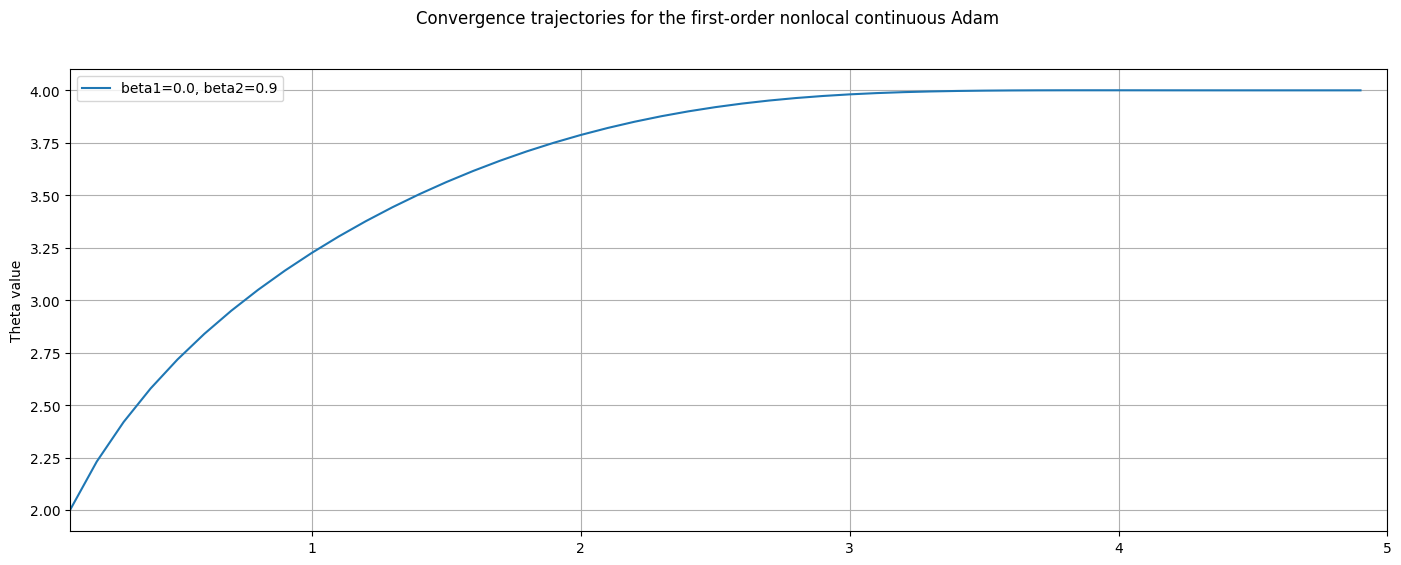

In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

param_grid = {'lr': [0.1], 'beta1': [0.0],'beta2': [0.9]}
n_learning_rates = len(param_grid['lr'])
param_list = list(ParameterGrid(param_grid))


fig, axs = plt.subplots(ncols=n_learning_rates, figsize=(17, 6), sharex=False, sharey=True)   
fig.suptitle('Convergence trajectories for the first-order nonlocal continuous Adam')

f = lambda x, y: 0.0
dL = lambda y: 2 * (y - 4)

for i, lr in enumerate(param_grid['lr']):

    ax = axs[i] if n_learning_rates > 1 else axs
    filtered_params = [p for p in param_list if p['lr'] == lr]

    if lr == 0.1:
        t = [0.1, 5]
    elif lr == 0.01:
        t = [1e-12, 4]

    for params in filtered_params:
        print(f'\nNonlocal Continuous Adam Configuration: {params}')
        solver = NonlocalSolverMomentum(f=f, dL=dL, t_span=t, y0=np.array([2.0]), alpha=params['lr'],
                                betas=[params['beta1'], params['beta2']])
        t_values, y_values = solver.solve()
        
        label = f"beta1={params['beta1']}, beta2={params['beta2']}"
        ax.plot(t_values, y_values, label=label)
        ax.set_ylabel('Theta value')
        ax.legend(loc = 'best')
        ax.grid(True)
        ax.set_xlim([t[0], t[1]])

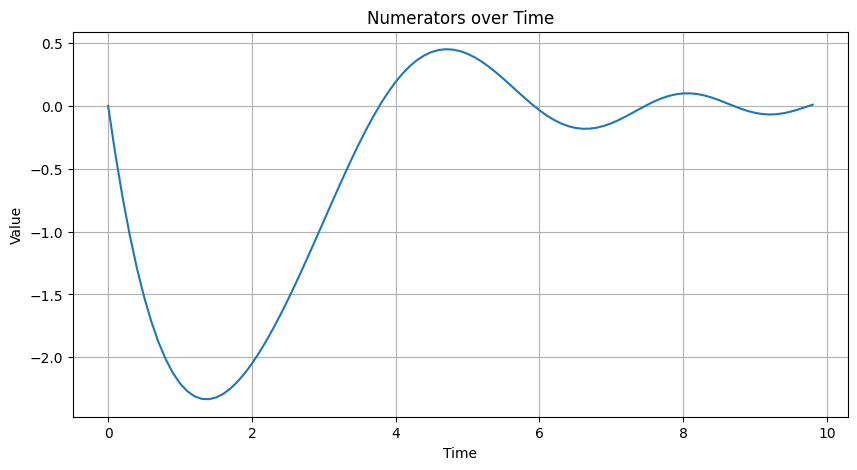

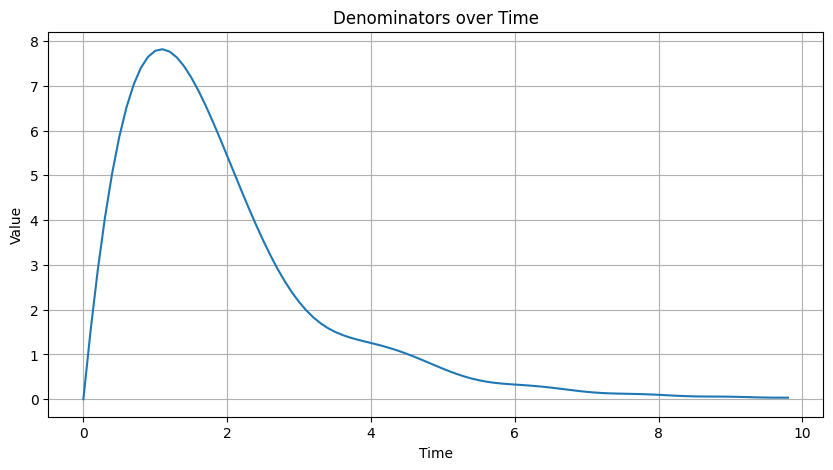

In [14]:
numerators = solver.m
denominators = solver.v

def plot_values(values, title):
    times = [item[0] for item in values]
    vals = [item[1] for item in values]

    plt.figure(figsize=(10, 5))
    plt.plot(times, vals, label='Values over Time m_hat')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_values(numerators, 'Numerators over Time')
plot_values(denominators, 'Denominators over Time')